## Getting Started

- Download MapPLUTO data from [NYC DCP](https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyc_mappluto_24v1_1_shp.zip)
- Unzip the file and place contents in the `Data` directory at the root of this repo
- Make sure you have installed all requisite libraries by running `pip install -r requirements.txt` **_with your virtual environment activated_**

## Goals

- Load data from file
- Explore spatial and non-spatial elements of the dataset
- Compare tradeoffs between different methods of loading data
- Demonstrate tradeoffs in different file formats


In [1]:
# the bare minimum
import matplotlib.pyplot as plt
import geopandas as gpd

# more advanced
import pyogrio as ogr
from sklearn.cluster import KMeans
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap, apply_continuous_cmap
from palettable.colorbrewer.sequential import PuRd_9
from matplotlib.colors import LogNorm

import pydeck as pdk

# load PLUTO data


In [2]:
# pluto = gpd.read_file("C:\Users\daiyu\Documents\GitHub\cdp-mapping-systems\Data\nyc_mappluto_24v1_1_shp\MapPLUTO.shp.xml")

In [3]:
pluto_ogrio = ogr.read_dataframe(r"C:\Users\daiyu\Documents\GitHub\cdp-mapping-systems\Data\nyc_mappluto_24v1_1_shp\MapPLUTO.shp")

# basic exploration


In [4]:
pluto_ogrio.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [5]:
pluto_ogrio.dtypes

Borough         object
Block            int64
Lot              int32
CD               int32
BCT2020         object
                ...   
Longitude      float64
Notes           object
Shape_Leng     float64
Shape_Area     float64
geometry      geometry
Length: 95, dtype: object

## categorical column


In [24]:
pluto_ogrio.YearBuilt.value_counts().sort_values()

YearBuilt
1665        1
1694        1
1706        1
1750        1
1729        1
        ...  
1910    41818
1950    47197
1925    69530
1930    74755
1920    87447
Name: count, Length: 252, dtype: int64

In [ ]:
def categorize_building(r):
    if r.YearBuilt < 1900:
        return "Pre-1900"
    elif r.YearBuilt < 1950:
        

🧐 What do those numbers mean? Let's look at the [data dictionary](https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/meta_mappluto.pdf)


In [13]:
# now we can remap the numbers into something more meaningful

land_use_codes = {
    "01": "1601-1650",
    "02": "1651-1700",
    "03": "1701-1750",
    "04": "1751-1800",
    "05": "1801-1850",
    "06": "1851-1900",
    "07": "1901-1950",
}

In [14]:
pluto_ogrio["Yearbuilt"] = pluto_ogrio.YearBuilt.map(land_use_codes)

## Your turn:

- How many lots of each land use type are there?
  - Use `groupby` to determine the number of lots of each land use type
- What is the lot area of each land use type?
  - Use `groupby` to make a bar chart that shows the average lot area of each land use type
- Can you find the total number of lots that contain `Commercial & Office Buildings` in the Bronx?
  - use groupby on multiple columns to achieve this
- Can you find the share of each land use type in each borough?


In [17]:
pluto_ogrio.groupby(["Block","YearBuilt"])

## Okay, now let's look at lot and building area


Text(0.5, 1.0, 'YearBuilt')

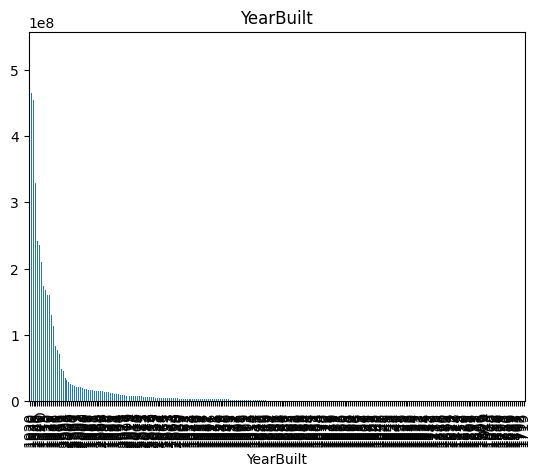

In [23]:
pluto_ogrio.groupby("YearBuilt").Block.sum().sort_values(ascending=False).plot.bar()
plt.title("YearBuilt by Block")

Text(0.5, 1.0, 'Total building area by land use type')

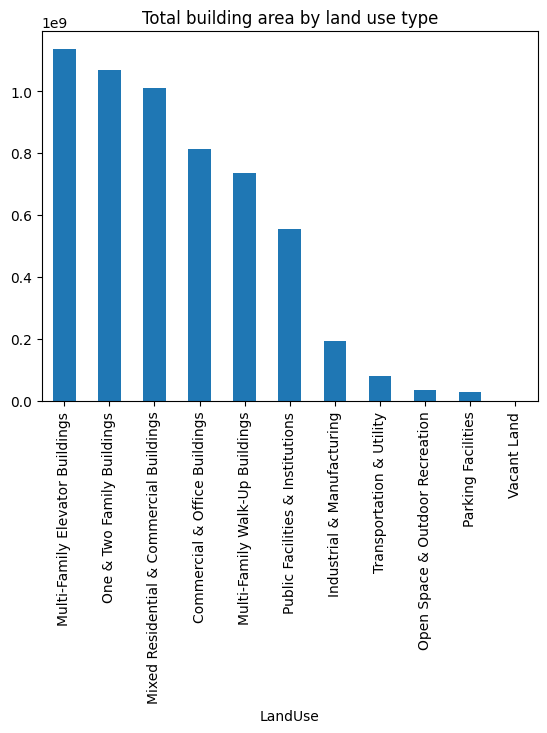

In [11]:
# now the same but for building area
pluto_ogrio.groupby("Yearbuilt").BldgArea.sum().sort_values(ascending=False).plot.bar()
plt.title("Total building area by land use type")

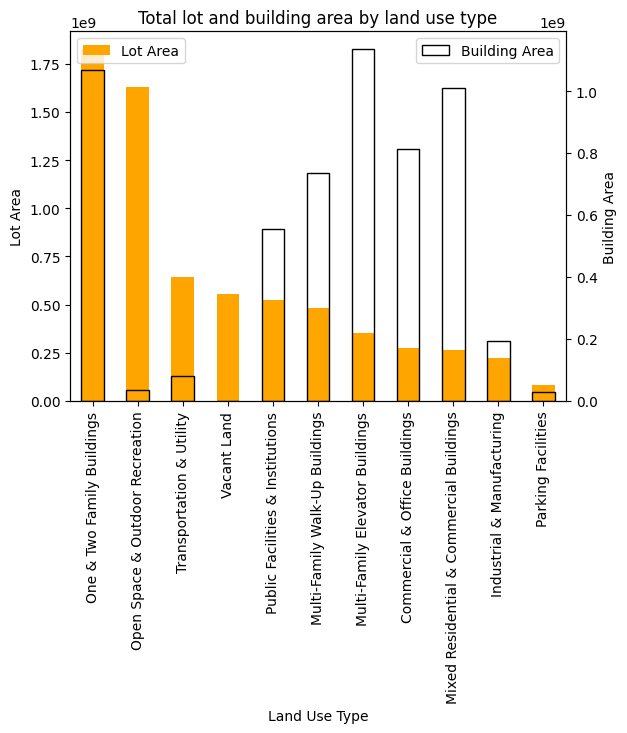

In [12]:
# plot both lot and building area on the same plot with a secondary y-axis
fig, ax = plt.subplots()
by_lot_area = pluto_ogrio.groupby("LandUse").LotArea.sum().sort_values(ascending=False)

by_lot_area.plot.bar(ax=ax, color="orange")

# get order to apply below
order = {v: i for i, v in enumerate(by_lot_area.index)}

ax.set_ylabel("Lot Area")
ax.set_xlabel("Land Use Type")

ax2 = ax.twinx()
pluto_ogrio.groupby("LandUse").BldgArea.sum().reindex(by_lot_area.index).plot.bar(
    ax=ax2, edgecolor="black", color="none"
)
ax2.set_ylabel("Building Area")

plt.title("Total lot and building area by land use type")

# add legends
ax.legend(["Lot Area"], loc="upper left")
ax2.legend(["Building Area"], loc="upper right")

## numeric column


In [13]:
pluto_ogrio.NumFloors.nunique()

176

In [14]:
pluto_ogrio["NumFloors"].describe()

count    856819.000000
mean          2.357554
std           2.012707
min           0.000000
25%           2.000000
50%           2.000000
75%           2.500000
max         104.000000
Name: NumFloors, dtype: float64

<Axes: ylabel='Frequency'>

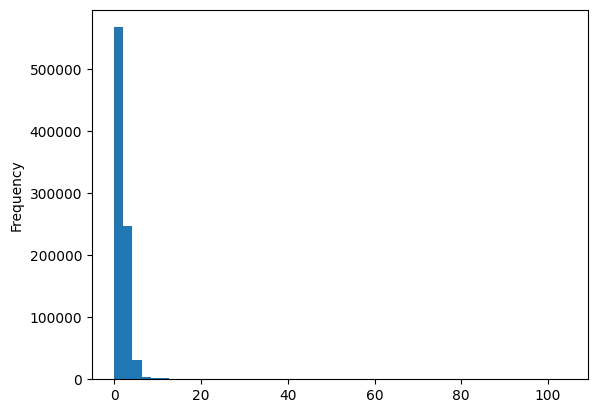

In [15]:
pluto_ogrio["NumFloors"].plot.hist(bins=50)

## Your turn:

- make a histogram for each borough like above
- then, choose another chart type to visualize the distribution of lot area for each borough. See [here](https://matplotlib.org/stable/plot_types/index.html) for some built in options in matplotlib, or here for [seaborn](https://seaborn.pydata.org/tutorial/distributions.html)


## Ok, now let's make a boxplot to see how wide the range is within each boro's data


<Axes: title={'center': 'NumFloors'}, xlabel='Borough'>

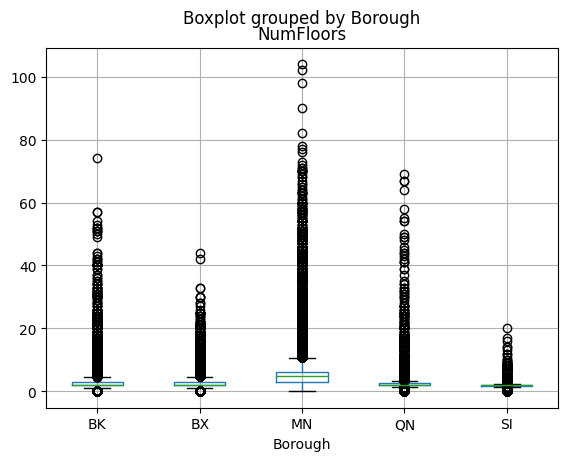

In [16]:
pluto_ogrio.boxplot(column="NumFloors", by="Borough")

What does this distribution tell us about the number of floors in each borough?


# cluster by number of floors


In [17]:
# get clusters using kmeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(pluto_ogrio[["NumFloors", "ResArea"]])

pluto_ogrio["NumFloorsCluster"] = kmeans.predict(pluto_ogrio[["NumFloors", "ResArea"]])

c:\Users\daiyu\.conda\envs\cdp_mapping\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\daiyu\.conda\envs\cdp_mapping\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\daiyu\.conda\envs\cdp_mapping\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\daiyu\.conda\envs\cdp_mapping\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\daiyu\.conda\envs\cdp_mapping\Lib\subprocess.py",

In [18]:
pluto_ogrio.groupby("NumFloorsCluster").NumFloors.describe().sort_values("max")

,count,mean,std,min,25%,50%,75%,max
NumFloorsCluster,,,,,,,,
2,4.0,19.500000,9.255629,13.0,13.75,16.0,21.75,33.0
4,1.0,33.000000,NaN,33.0,33.00,33.0,33.00,33.0
3,5400.0,12.765972,9.722526,0.0,6.00,10.0,16.00,90.0
1,439.0,24.089977,16.264628,0.0,13.00,20.0,33.00,98.0
0,850975.0,2.280178,1.550174,0.0,2.00,2.0,2.50,104.0


<Axes: xlabel='NumFloors', ylabel='ResArea'>

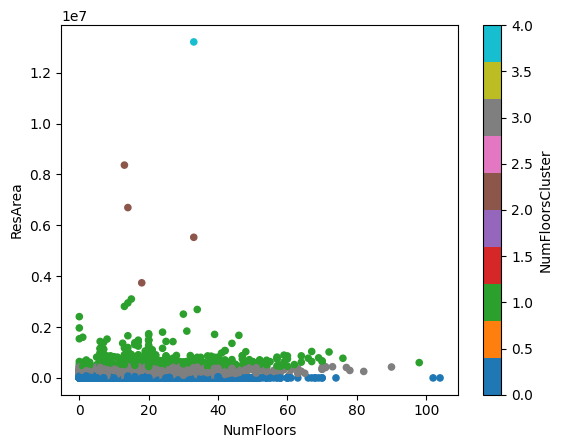

In [19]:
pluto_ogrio.plot.scatter(x="NumFloors", y="ResArea", c="NumFloorsCluster", cmap="tab10")

<Axes: xlabel='NumFloors', ylabel='ResArea'>

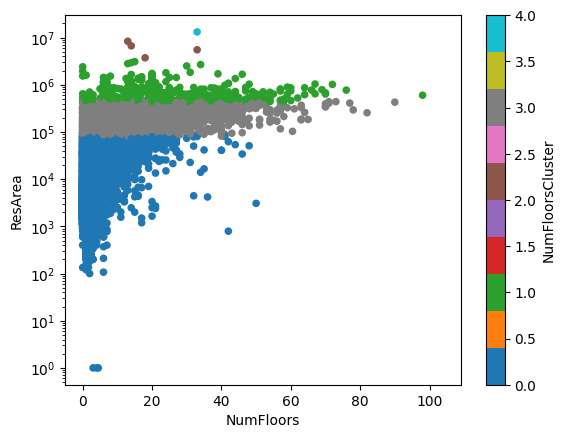

In [20]:
# same as above but with log y axis
pluto_ogrio.plot.scatter(
    x="NumFloors", y="ResArea", c="NumFloorsCluster", cmap="tab10", logy=True
)

<Axes: ylabel='Frequency'>

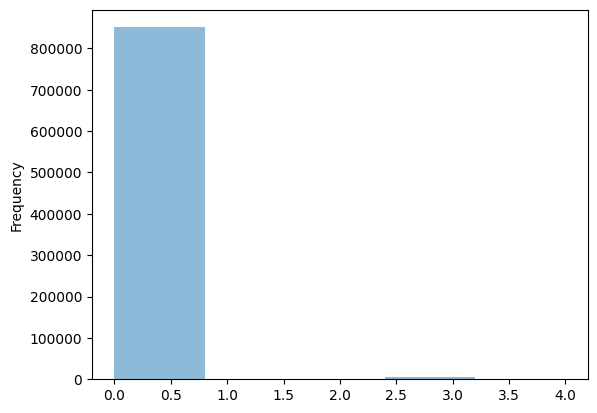

In [21]:
pluto_ogrio["NumFloorsCluster"].plot.hist(bins=5, alpha=0.5)

# and now, mapping


## static map


Text(0.5, 1.0, 'NYC MapPLUTO')

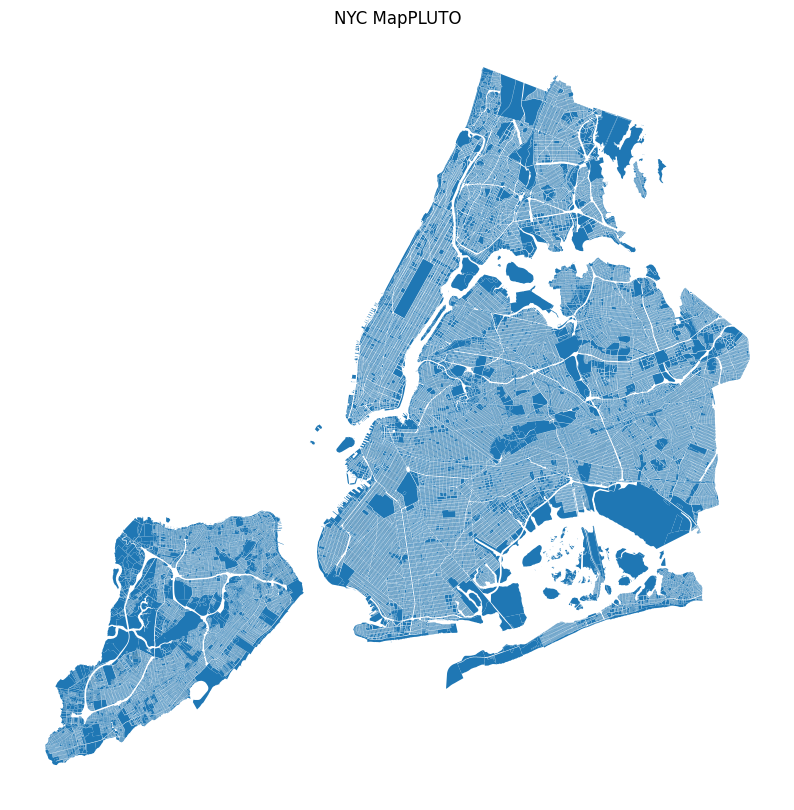

In [22]:
pluto_ogrio.plot(figsize=(10, 10)).set_axis_off()
plt.title("NYC MapPLUTO")

In [23]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}

In [24]:
pluto_ogrio.fillna({"Yearbuilt": "Unknown"}, inplace=True)

In [25]:
pluto_ogrio["color"] = pluto_ogrio["Yearbuilt"].map(cmap)

In [21]:
ax = pluto_ogrio.plot(
    color=pluto_ogrio["color"],
    figsize=(10, 10),
    legend=True,
).set_axis_off()
plt.title("NYC MapPLUTO")


# populate legend items based on dict from above
legend_colors = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=c, markersize=10)
    for c in cmap.values()
]
labels = cmap.keys()
plt.legend(legend_colors, labels, loc="upper left")

KeyError: 'color'

Text(0.5, 1.0, 'NYC MapPLUTO')

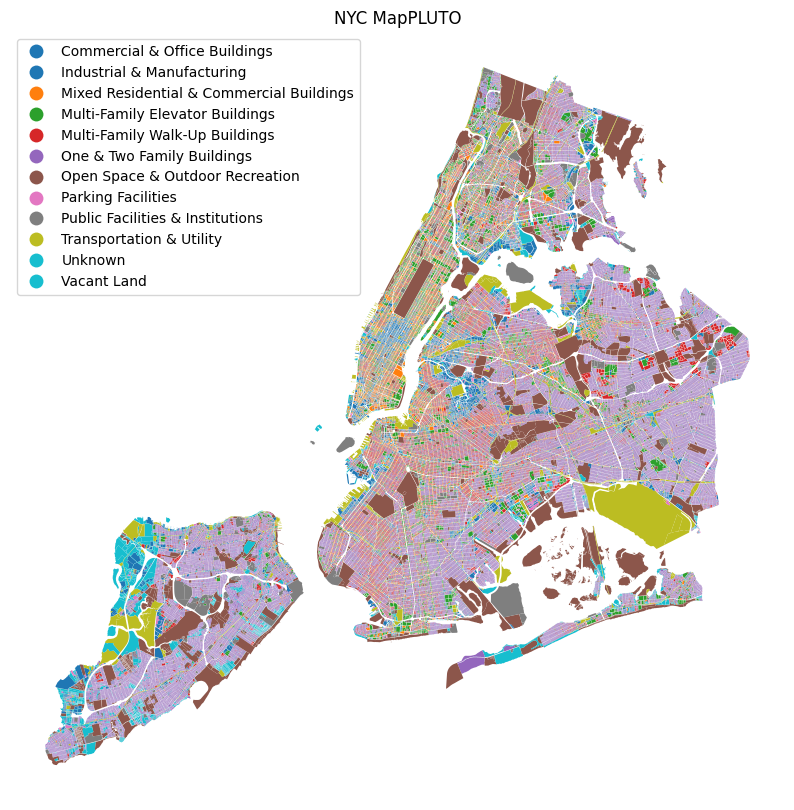

In [27]:
pluto_ogrio.plot(
    column="LandUse", figsize=(10, 10), legend=True, legend_kwds={"loc": "upper left"}
).set_axis_off()
plt.title("NYC MapPLUTO")

## Your turn:

- map a numeric column using a continuous colormap for Queens. See here for a list and discussion of colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
- What patterns emerge?


In [28]:
pluto_ogrio.Borough

0         MN
1         MN
2         MN
3         MN
4         MN
          ..
856814    SI
856815    SI
856816    SI
856817    SI
856818    SI
Name: Borough, Length: 856819, dtype: object

<Axes: >

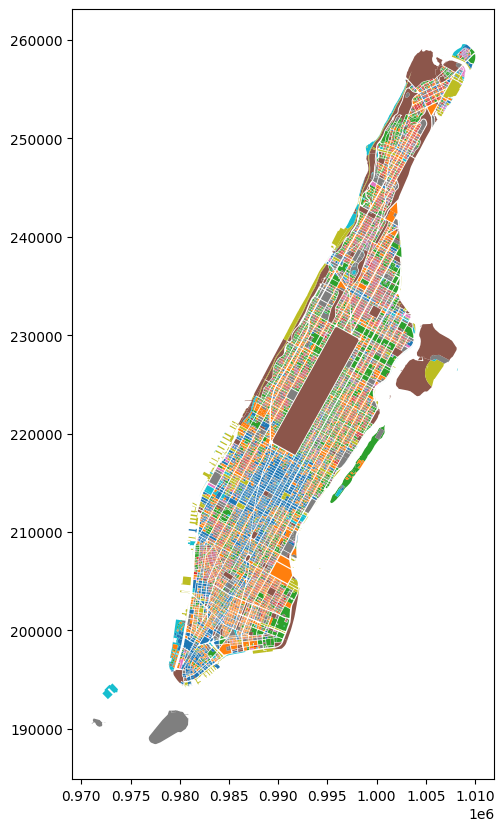

In [29]:
pluto_ogrio[pluto_ogrio.Borough.eq('MN')].plot(column="LandUse", figsize=(10,10))

# prep for interactive mapping


In [30]:
pluto_ogrio.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [31]:
pluto_ogrio_wgs = pluto_ogrio.to_crs("epsg:4326")

## visualize a categorical variable


In [32]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

In [33]:
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [34]:
len(pluto_ogrio_wgs[pluto_ogrio_wgs["LandUse"].isna()])

0

In [35]:
pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)

C:\Users\daiyu\AppData\Local\Temp\ipykernel_8372\961482650.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pluto_ogrio_wgs["LandUse"].fillna("Unknown", inplace=True)


## uhoh- observe the above warning- re-write the code to avoid this


## now, we can plot the data using lonboard to create an interactive map


In [36]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x0000016C2747B820>
[
  [
  …

In [37]:
pluto_ogrio_wgs["LandUse"] = pluto_ogrio_wgs["LandUse"].astype("category")

In [38]:
df = pluto_ogrio_wgs[["LandUse", "geometry"]]

layer = PolygonLayer.from_geopandas(
    df[["LandUse", "geometry"]],
    get_fill_color=apply_categorical_cmap(df["LandUse"], cmap=cmap_rgb),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x0000016C2747BFA0>
[
  [
  …

In [39]:
pluto_ogrio_wgs[pluto_ogrio_wgs.geometry.isna()]

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry,NumFloorsCluster,color


## visualize a continuous variable


In [40]:
df = pluto_ogrio_wgs[["NumFloors", "geometry"]]

normalizer = LogNorm(1, df.NumFloors.max(), clip=True)
normalized_floors = normalizer(df.NumFloors)

layer = PolygonLayer.from_geopandas(
    df[["NumFloors", "geometry"]],
    get_fill_color=apply_continuous_cmap(normalized_floors, cmap=PuRd_9),
)
m = Map(layer)
m

Map(layers=[PolygonLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x0000016D22810100>
[
  [
  …

## your turn: can you make the above show in 3d?

- see here for some tips: https://developmentseed.org/lonboard/latest/examples/overture-maps/#imports


# save data


In [ ]:
# save out as fgb using geopandas
# pluto_ogrio.to_file("..Data/nyc_mappluto_24v1_1_shp/mappluto.fgb")

In [ ]:
# ogr.write_dataframe(pluto_ogrio, "../Data/nyc_mappluto_24v1_1_shp/mappluto_ogr.fgb")